17.3 Simple portfolio optimization

In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [8]:
np.random.seed(1)
n = 20
pbar = np.ones((n,1))*.03 + np.r_[np.random.rand(n-1,1), np.zeros((1,1))]*.12
S = np.random.randn(n, n); S = np.asmatrix(S)
S = S.T*S
S = S/max(np.abs(np.diag(S)))*.2
S[:, -1] = np.zeros((n, 1))
S[-1, :] = np.zeros((n, 1)).T
x_unif = np.ones((n, 1))/n

In [16]:
unif_return = pbar.T @ x_unif
print(x_unif.T @ S @ x_unif) # risk of the uniform portfolio

[[0.004437]]


In [25]:
# No constraints
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [cp.sum(x) == 1, pbar.T @ x >= unif_return]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print("{:.6f}".format(objective.value))
# Long only
x = cp.Variable(n, nonneg=True)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [cp.sum(x) == 1, pbar.T @ x >= unif_return]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print("{:.6f}".format(objective.value))
# Limit on total short position
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [
    cp.sum(x) == 1, 
    pbar.T @ x >= unif_return,
    (cp.norm(x, 1) - 1) / 2 <= 0.5
    ]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print("{:.6f}".format(objective.value))

0.000082
0.001560
0.000224


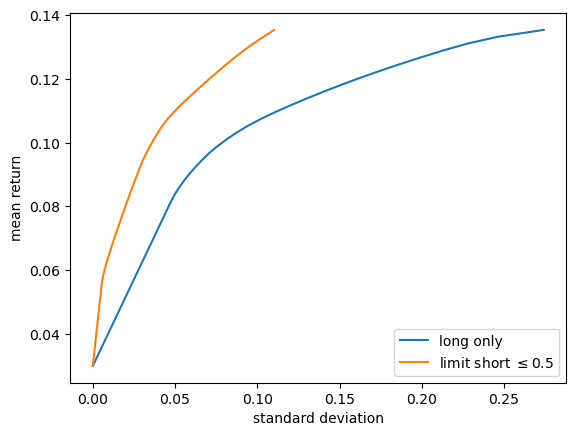

In [35]:
std_lo, returns_lo, std_ls, returns_ls = [], [], [], []
for return_goal in np.linspace(min(pbar), max(pbar)):
    # Long only
    x = cp.Variable(n, nonneg=True)
    objective = cp.Minimize(cp.quad_form(x, S))
    constraints = [cp.sum(x) == 1, pbar.T @ x >= return_goal]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    returns_lo.append(pbar.T @ x.value)
    std_lo.append(np.sqrt(objective.value))
    # limit short
    x = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(x, S))
    constraints = [cp.sum(x) == 1, pbar.T @ x >= return_goal, (cp.norm(x, 1) - 1) / 2 <= 0.5]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    returns_ls.append(pbar.T @ x.value)
    std_ls.append(np.sqrt(objective.value))
    
fig, ax1 = plt.subplots(1, 1, sharex=True)
ax1.plot(std_lo, returns_lo, label='long only')
ax1.plot(std_ls, returns_ls, label='limit short $\leq 0.5$')
ax1.set_ylabel('mean return')
ax1.set_xlabel('standard deviation')
ax1.legend()
plt.show()